In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import scipy.signal as scisig
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import neurokit2 as nk
from biosppy.signals import ecg, resp

sns.set_palette("colorblind")

In [2]:
file_name = "../WESAD/S2/S2"

with open(f"{file_name}.pkl", 'rb') as f:
    s_data = pickle.load(f, encoding="latin1")

In [3]:
df_label = pd.DataFrame(s_data['label'])
df_label.columns = ['label']
df_label

df_EDA = pd.DataFrame(s_data['signal']['chest']['EDA'])
df_EDA.columns = ['EDA']

df_EdaLabel = pd.concat([df_EDA, df_label], axis=1)
df_EdaLabel1 = df_EdaLabel.query('label == 0')
df_EdaLabel2 = df_EdaLabel.query('label == 1')
df_EdaLabel1

,EDA,label
0,5.250549,0
1,5.267334,0
2,5.243301,0
3,5.249405,0
4,5.286407,0
...,...,...
4255295,0.400162,0
4255296,0.355911,0
4255297,0.360489,0
4255298,0.365829,0


In [4]:
from numpy.random import choice

arrRoute1 = []
arrLabel1 = []
arrRoute2 = []
arrLabel2 = []

for i in range(0, len(df_EdaLabel1), 2800):
    figName = '../imgSpectograms/spect_s1_' + str(i) + '.png'
    arrRoute1.append(figName)
    arrLabel1.append(0)

for i in range(0, len(df_EdaLabel2), 2800):
    figName = '../imgSpectograms/spect_s2_' + str(i) + '.png'
    arrRoute2.append(figName)
    arrLabel2.append(1)

df1r = pd.DataFrame(arrRoute1, columns=['route'])
df1l = pd.DataFrame(arrLabel1, columns=['label'])
df2r = pd.DataFrame(arrRoute2, columns=['route'])
df2l = pd.DataFrame(arrLabel2, columns=['label'])

df1 = pd.concat([df1r, df1l], axis=1)
df1['split'] = choice(['Train', 'Test'], len(df1), p=[0.8, 0.2])
df2 = pd.concat([df2r, df2l], axis=1)
df2['split'] = choice(['Train', 'Test'], len(df2), p=[0.8, 0.2])

df = pd.concat([df1, df2])

df

,route,label,split
0,../imgSpectograms/spect_s1_0.png,0,Train
1,../imgSpectograms/spect_s1_2800.png,0,Train
2,../imgSpectograms/spect_s1_5600.png,0,Train
3,../imgSpectograms/spect_s1_8400.png,0,Test
4,../imgSpectograms/spect_s1_11200.png,0,Train
...,...,...,...
281,../imgSpectograms/spect_s2_786800.png,1,Train
282,../imgSpectograms/spect_s2_789600.png,1,Train
283,../imgSpectograms/spect_s2_792400.png,1,Train
284,../imgSpectograms/spect_s2_795200.png,1,Test


In [5]:
import torch
import torchvision
import numpy as np
from numpy import asarray
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

class Dataset(torch.utils.data.Dataset):
    def __init__(self, train=True, pctg=1.):
        self.classes = (0, 1)
        imgArr = []
        if train == True:
            df = df.query('split == "Train"')
            for i in df['route']:
                img = load_img(i)
                img_array = img_to_array(img)
                imgArr.append(img_array)
        else:
            df = df.query('split == "Test"')
            for i in df['route']:
                img = load_img(i)
                img_array = img_to_array(img)
                imgArr.append(img_array)
        self.imgs = imgArr
        self.labels = df['label'].to_numpy()
        if pctg < 1.:
            unique_labels = list(range(len(self.classes)))
            filtered_imgs, filtered_labels = [], []
            for lab in unique_labels:
                ixs = (self.labels == lab)
                lim = int(ixs.sum()*pctg)
                filtered_imgs += self.imgs[ixs][:lim].tolist()
                filtered_labels += self.labels[ixs][:lim].tolist()
            self.imgs, self.labels = np.array(filtered_imgs), np.array(filtered_labels)
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        return torch.from_numpy(img / 255.).permute(2,0,1).float(), torch.tensor(self.labels[ix]).long()

class SSLDataset(torch.utils.data.Dataset):
    def __init__(self, trans):
        self.trans = trans
        imgArr = []
        for i in df['route']:
            img = load_img(i)
            img_array = img_to_array(img)
            imgArr.append(img_array)
        self.imgs = imgArr
        self.labels = df['label'].to_numpy()
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        img1 = self.trans(image=img)['image']
        img2 = self.trans(image=img)['image']
        return torch.from_numpy(img1 / 255.).permute(2,0,1).float(), torch.from_numpy(img2 / 255.).permute(2,0,1).float()

In [6]:
batch_size = 1024
num_workers = 24

In [7]:
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd

def step(model, batch, device):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.size(0)
    return loss, acc

def train(model, dl, optimizer, epochs=10, device="cuda"):
    model.to(device)
    hist = {'loss': [], 'acc': [], 'test_loss': [], 'test_acc': []}
    for e in range(1, epochs+1):
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl['train'])
        for batch in bar:
            optimizer.zero_grad()
            loss, acc = step(model, batch, device)
            loss.backward()
            optimizer.step()
            l.append(loss.item())
            a.append(acc)
            bar.set_description(f"training... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['loss'].append(np.mean(l))
        hist['acc'].append(np.mean(a))
        # eval
        model.eval()
        l, a = [], []
        bar = tqdm(dl['test'])
        with torch.no_grad():
            for batch in bar:
                loss, acc = step(model, batch, device)
                l.append(loss.item())
                a.append(acc)
                bar.set_description(f"testing... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['test_loss'].append(np.mean(l))
        hist['test_acc'].append(np.mean(a))
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            log += f' {k} {v[-1]:.4f}'
        print(log)
    return hist

def plot_hist(hist):
  fig = plt.figure(figsize=(10, 3), dpi=100)
  df = pd.DataFrame(hist)
  ax = plt.subplot(1, 2, 1)
  df[['loss', 'test_loss']].plot(ax=ax)
  ax.grid(True)
  ax = plt.subplot(1, 2, 2)
  df[['acc', 'test_acc']].plot(ax=ax)
  ax.grid(True)
  plt.show()

In [8]:
import albumentations as A

trans = A.Compose([
    A.RandomResizedCrop(32, 32),
    A.HorizontalFlip(p=0.5),
    #A.ColorJitter(p=0.3),
    #A.ToGray(p=0.3),
    A.GaussianBlur(),
    #A.Solarize(p=0.3)
])

SSLds = SSLDataset(trans)

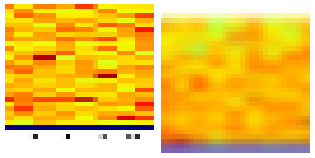

In [9]:
import matplotlib.pyplot as plt
import random

ix = random.randint(0, len(SSLds))
img1, img2 = SSLds[ix]
fig = plt.figure(dpi=50)
ax = plt.subplot(1, 2, 1)
ax.imshow(img1.permute(1,2,0))
ax.axis('off')
ax = plt.subplot(1, 2, 2)
ax.imshow(img2.permute(1,2,0))
ax.axis('off')
plt.tight_layout()
plt.show()

In [10]:
class SSLModel(torch.nn.Module):

    def __init__(self, f=512):
        super().__init__()
        self.backbone = torch.nn.Sequential(*list(torchvision.models.resnet18().children())[:-1])
        self.head = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(512, f),
            torch.nn.BatchNorm1d(f),
            torch.nn.ReLU(),
            torch.nn.Linear(f, f),
            torch.nn.BatchNorm1d(f),
            torch.nn.ReLU(),
            torch.nn.Linear(f, f)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

In [11]:
SSLmodel = SSLModel()
output = SSLmodel(torch.randn(32, 3, 32, 32))

output.shape

torch.Size([32, 512])

In [12]:
import copy

class FTModel(torch.nn.Module):

    def __init__(self, backbone='SSLbackbone.pt', n_outputs=10):
        super().__init__()
        self.backbone = torch.jit.load(backbone)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.head = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(512, n_outputs)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

In [13]:
from tqdm import tqdm

def SSLeval(SSLmodel):
    torch.jit.script(SSLmodel.backbone.cpu()).save('SSLbackbone.pt')
    ds = {
        'train': Dataset(),
        'test': Dataset(train=False)
    }
    batch_size = 1024
    dl = {
        'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
    }
    FTmodel = FTModel('SSLbackbone.pt')
    optimizer = torch.optim.Adam(FTmodel.parameters(), lr=1e-3)
    hist = train(FTmodel, dl, optimizer, epochs=3)
    return hist['acc'][-1], hist['test_acc'][-1]

def SSLstep(model, batch, device, l=5e-3):
    # Dos versiones aumentadas aleatoriamente de x
    x1, x2 = batch
    x1, x2 = x1.to(device), x2.to(device)

    # Calcular representaciones
    z1 = model(x1)
    z2 = model(x2)

    # normalizar repr. a lo largo de la dimensión del batch
    N, D = z1.shape
    z1_norm = (z1 - z1.mean(0)) / z1.std(0) # NxD
    z2_norm = (z2 - z2.mean(0)) / z2.std(0) # NxD

    # Matriz de cross-correlation
    c = (z1_norm.T @ z2_norm) / N # DxD

    # loss
    c_diff = (c - torch.eye(D, device=device)).pow(2) # DxD

    # multiplicar elementos fuera de la diagonal de c_diff por lambda
    d = torch.eye(D, dtype=bool)
    c_diff[~d] *= l
    return c_diff.sum()

def SSLtrain(model, dl, optimizer, scheduler, epochs=10, device="cuda", eval_each=10):
    hist = {'loss': [], 'acc': [], 'test_acc': []}
    for e in range(1, epochs+1):
        model.to(device)
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl)
        for batch in bar:
            optimizer.zero_grad()
            loss = SSLstep(model, batch, device)
            loss.backward()
            optimizer.step()
            l.append(loss.item())
            bar.set_description(f"training... loss {np.mean(l):.4f}")
        hist['loss'].append(np.mean(l))
        scheduler.step()
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            if len(v) > 0:
                log += f' {k} {v[-1]:.4f}'
        print(log)
        # eval
        if not e % eval_each:
            print("evaluating ...")
            val_train_acc, val_test_acc = SSLeval(model)
            hist['acc'].append(val_train_acc)
            hist['test_acc'].append(val_test_acc)
    return hist

In [14]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce GTX 1060


In [15]:
SSLdl = torch.utils.data.DataLoader(SSLds, batch_size=1024, shuffle=True, num_workers=num_workers)
SSLmodel = SSLModel()
optimizer = torch.optim.Adam(SSLmodel.parameters(), lr=1e-4)
epochs = 500
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, pct_start=0.01, max_lr=0.1, total_steps=epochs, verbose=True)
hist = SSLtrain(SSLmodel, SSLdl, optimizer, scheduler, epochs=epochs)

c:\Users\jjjni\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:560: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Adjusting learning rate of group 0 to 4.0000e-03.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
fig = plt.figure(figsize=(10, 3), dpi=100)
ax = plt.subplot(1, 2, 1)
ax.plot(hist['loss'])
ax.legend(['loss'])
ax.grid(True)
ax = plt.subplot(1, 2, 2)
ax.plot(hist['acc'])
ax.plot(hist['test_acc'])
ax.legend(['acc', 'test_acc'])
ax.grid(True)
plt.show()